<a href="https://colab.research.google.com/github/Ashi743/deep-learning-/blob/main/keras_customer_churn_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F869651%2F1481789%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241011%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241011T094120Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2dee35f429267a275f0cabc3832120e6524dc6a94513be4a871ab0c0342a8c9760e90d53de697274cc701eac5004cf780bd5996ea83786633a2f46fa054f89c6e318530f589fea87b8cc3a9c3bd9f389d2ba9ec72cfa1cf9f28f659dda38706d4a12c9cbdb4f26c3cfc1e81814a45bdbc1d08068e50c1dde10a287e923f7708a74169cf53c3216462a933a20d05b7f9d8ef446eea3d0bfc3424c6952378f0d4e0ecd6b64a48c747fb7ee926695bf9e12f1b8edcf83a03bd246a6443050afe9cae55403f2418e47228159c2ff09570579d5e07e5d1bef29d8f9f85651415d7701fccfedfabe592cca31900214ed607f259aa4c025108df973ed9a84eaca8e84b6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: credit-card-customer-churn-prediction
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [4]:
df= pd.read_csv("/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv")

In [5]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
df.drop(columns= ['RowNumber', 'CustomerId', 'Surname'], inplace=True)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df= pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)

In [8]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [9]:
X= df.drop(columns=['Exited'])
Y= df['Exited']

In [10]:
#scale before neural network
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test= train_test_split(X,Y,test_size=0.2 ,random_state= 42)

In [11]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
X_train_scaled =ss.fit_transform(X_train)
X_test_scaled=  ss.transform(X_test)

In [12]:
df_scaled= pd.DataFrame(X_train_scaled , columns=X.columns)

In [13]:
df_scaled.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,0.356500,-0.655786,0.345680,-1.218471,0.808436,0.649203,0.974817,1.367670,-0.579467,-0.576388,0.913248
1,-0.203898,0.294938,-0.348369,0.696838,0.808436,0.649203,0.974817,1.661254,1.725723,-0.576388,0.913248


In [14]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [15]:
model =Sequential()
model.add(Dense(11, activation= 'relu', input_dim= 11) )    #layer 1  11*3+3
model.add(Dense(11, activation= 'relu') )
model.add(Dense(1, activation= 'sigmoid') )                   #layer 2  1*3+1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              12 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 276 (1.08 KB)

 Trainable params: 276 (1.08 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss= 'binary_crossentropy' ,optimizer="Adam", metrics=['accuracy'])
history= model.fit(X_train_scaled, Y_train, epochs=18, validation_split= 0.2)

Epoch 1/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6578 - loss: 0.6269 - val_accuracy: 0.8000 - val_loss: 0.4826
Epoch 2/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8017 - loss: 0.4664 - val_accuracy: 0.8181 - val_loss: 0.4379
Epoch 3/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8094 - loss: 0.4326 - val_accuracy: 0.8325 - val_loss: 0.4131
Epoch 4/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8293 - loss: 0.4042 - val_accuracy: 0.8381 - val_loss: 0.3977
Epoch 5/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8425 - loss: 0.3793 - val_accuracy: 0.8431 - val_loss: 0.3901
Epoch 6/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8470 - loss: 0.3737 - val_accuracy: 0.8450 - val_loss: 0.3834
Epoch 7/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8501 - loss: 0.3633 - val_accuracy: 0.8438 - val_loss: 0.3768
Epoch 8/18
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8535 - loss: 0.3477 - val_accuracy: 0.

In [18]:
model.layers[0].get_weights() #0th layer

[array([[-7.66905770e-02,  4.54527028e-02, -5.45958430e-02,
          2.43695989e-01, -1.32389963e-01,  1.78508028e-01,
         -3.64077002e-01,  1.31447703e-01,  5.07934317e-02,
          3.16432342e-02,  2.25654259e-01],
        [-1.38825417e-01,  1.38113305e-01, -5.66065647e-02,
          6.11849092e-02,  7.00072125e-02, -5.07245064e-01,
         -6.47432268e-01,  1.77056529e-02,  3.11088294e-01,
         -7.05699146e-01,  9.73237753e-02],
        [ 4.61230204e-02, -4.81925569e-02, -1.88977748e-01,
         -2.00768132e-02, -2.11575869e-02,  6.28921092e-02,
          3.17588598e-01,  9.72337127e-02,  1.94950327e-01,
         -2.04202428e-01,  5.52670993e-02],
        [ 1.47447780e-01,  4.07266289e-01,  5.33458889e-01,
         -3.80958766e-01, -3.68428558e-01, -3.20881680e-02,
          3.25544886e-02, -4.67969328e-01, -3.81995112e-01,
         -1.58266798e-01,  3.01799178e-02],
        [ 1.14655805e+00,  9.39768970e-01, -1.06630651e-02,
         -6.03531122e-01, -1.02260637e+00, -

In [19]:
y_log= model.predict(X_test_scaled)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [20]:
from sklearn.linear_model import  LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_scaled, Y_train)

LogisticRegression()

AUC: 0.7788998829864888


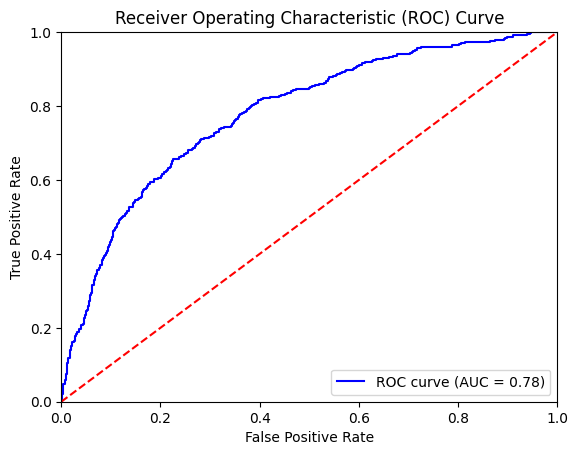

In [21]:
# Predicted probabilities for the positive class
y_probs = logreg.predict_proba(X_test_scaled)[:, 1]
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_probs)

# Calculate AUC
auc = roc_auc_score(Y_test, y_probs)
print(f"AUC: {auc}")

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [22]:
for i, threshold in enumerate(thresholds[:10]):  # Displaying first 10 for brevity
    print(f'Threshold: {threshold:.2f}, FPR: {fpr[i]:.2f}, TPR: {tpr[i]:.2f}')


Threshold: inf, FPR: 0.00, TPR: 0.00
Threshold: 0.92, FPR: 0.00, TPR: 0.00
Threshold: 0.87, FPR: 0.00, TPR: 0.00
Threshold: 0.83, FPR: 0.00, TPR: 0.01
Threshold: 0.82, FPR: 0.00, TPR: 0.01
Threshold: 0.79, FPR: 0.00, TPR: 0.02
Threshold: 0.78, FPR: 0.00, TPR: 0.02
Threshold: 0.77, FPR: 0.00, TPR: 0.03
Threshold: 0.75, FPR: 0.00, TPR: 0.03
Threshold: 0.74, FPR: 0.00, TPR: 0.03


In [23]:
optimal_idx = (tpr - fpr).argmax()  # Maximizing the difference
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.2f}')


Optimal Threshold: 0.24


In [24]:
y_pred =np.where(y_log>0.3, 1, 0)
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred)

0.819

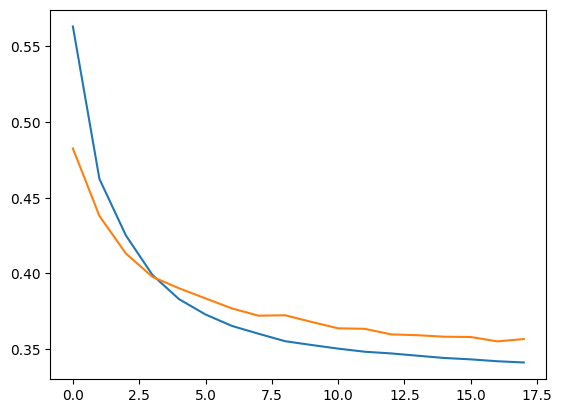

In [26]:
import matplotlib.pyplot as plt
history.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

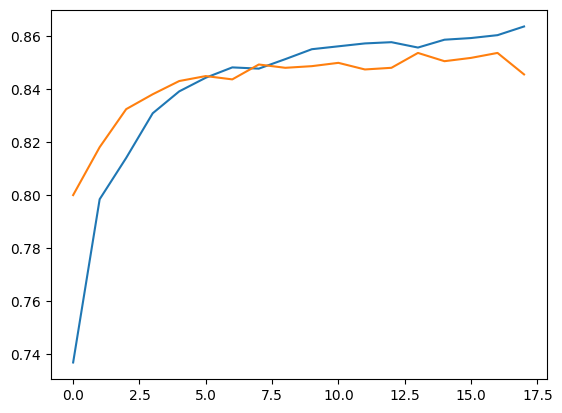

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])